## Figure 3: Visualization of the full perturbative error mitigation 

We will show the performance of the _general_ truncation scheme to recover the full bitstring distribution, as a function of cutoff weight $w$ for an example distribution.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

import utils
import response_matrix

In [6]:
# Utilities for making probability distributions

def gaussian(x, x0, sigma):
    return np.exp(-(x - x0)**2 / (2 * sigma**2)) / (np.sqrt(2 * np.pi) * sigma)

def nbit_gaussian(j, j0, n, sigma):
    """Compute the asymmetric gaussian centered at 0.
    """
    fullrange = 1 << n
    x = j / fullrange
    x0 = j0 / fullrange
    return gaussian(x, x0, sigma)/ (1 << n)

### Parameters for R matrix

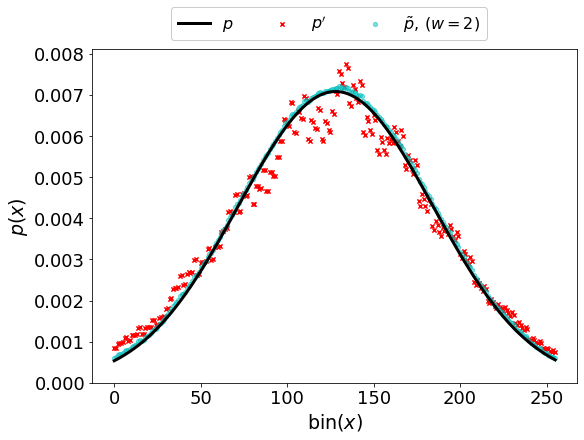

In [69]:
plt.style.use('./style.mplstyle')

wvals = [1, 2, 3, 4]
qfixed = .06 # characteristic rate for this exp
n_qubits = 8 # number of qubits
w_fixed = 2 # size of truncated space to use for recovery

# true distribution
x = np.arange(1 << n_qubits)
p_true = nbit_gaussian(x, 1 << (n_qubits-1), n_qubits, 0.22) 

# error distribution. seed for reproducibility
np.random.seed(13822)
R = response_matrix.generate_characteristic_R(qfixed, n_qubits)
p_prime = R @ p_true

# w=3 distribution
p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w_fixed, w2=w_fixed)

# plot params
s = 10
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)

ax.plot(x, p_true, c='k', lw=3, label=r"$p$")
ax.scatter(x, p_prime, s=18, c='r', marker='x', label=r"$p'$")
ax.scatter(x, p_fixed, s=18, c='c', marker='o', alpha=0.5, label=r"$\tilde{p}, \, (w=$" + f"{w_fixed}" + r"$)$")

ax.legend(bbox_to_anchor=(0.83, 1.15), framealpha=1, ncol=3, prop={'size': 16}) # override legend prop
ax.set_ylim(0, ax.get_ylim()[1])
ax.set_ylabel(r"$p(x)$")
ax.set_xlabel("bin" + r"$(x)$")

fig.savefig("figures/figure3.pdf")

In [8]:
# Baseline contains the uncorrected distribution comparison to ptrue
baseline = np.zeros(len(nqubits_lst))
# Outcomes contain truncated result comparisons
outcomes = np.zeros((len(wvals), len(nqubits_lst))) # rows correspond to w=1,2...

for j, n_qubits in enumerate(nqubits_lst):
    # Generate response matrix and artificial readout error
    R = response_matrix.generate_characteristic_R(qfixed, n_qubits)
    p_true = nbit_guassian(n_qubits)
    p_prime = R @ p_true
    
    # Full distribution correction
    baseline[j] = trace_dist(p_prime, p_true)
    for k, w in enumerate(wvals):
        p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
        outcomes[k,j] = trace_dist(p_fixed, p_true)
        
# Second experiment
# Note that this is somewhat unstable with respect to sampling variance 
# in the elements of R. For this reason I average out over some trials

ntrials = 8
qvals = np.linspace(0.01, 0.15, 16)
n_qubits = 10

# Outcomes contain truncated result comparisons
q_outcomes = np.zeros((len(wvals) + 1, len(qvals), ntrials)) # rows correspond to w=0, 1,2...

for trial in range(ntrials):
    for j, qmax in enumerate(qvals):
        # Generate response matrix and artificial readout error
        R = generate_R(qmax, n_qubits)
        Rinv = np.linalg.inv(R)
        p_true = make_random(n_qubits)
        p_prime = R @ p_true

        # Full distribution correction
        q_outcomes[0, j, trial] = trace_dist(p_prime, p_true)
        for k, w in enumerate(wvals):
            p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
            q_outcomes[k + 1,j, trial] = trace_dist(p_fixed, p_true)

np.save("{}qubits_scaling_results.npy".format(n_qubits), q_outcomes)

NameError: name 'nqubits_lst' is not defined

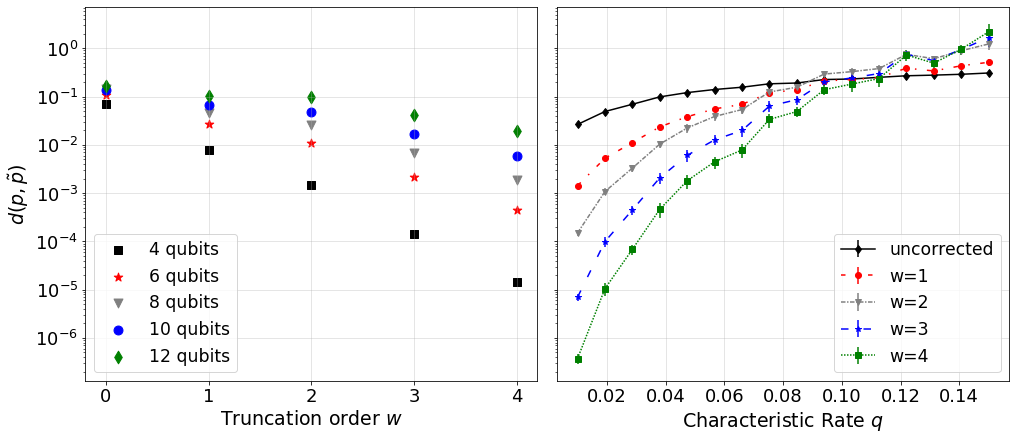

In [70]:
plt.style.use('./style.mplstyle')
fig, axes = plt.subplots(1, 2, figsize=(14, 6), constrained_layout=True, sharey=True)


all_outcomes = np.vstack((baseline, outcomes))

x = np.asarray([0] + wvals)

leglabs = [f"{x} qubits" for x in nqubits_lst]
markers = ['s', '*', 'v', 'o', 'd']
colors = ['k', 'r', 'gray', 'b', 'g']

# Full distr results
for j, y in enumerate(all_outcomes.T):
    axes[0].scatter(x, y, label=leglabs[j], marker=markers[j], s=80, c=colors[j])
    
# Ideally one could overlay a bound derived in the paper
# but unfortunately we've used two different error metrics (L2 vs. L1)...
# axes[0].scatter(x, (2 * qfixed) ** (x+1))

axes[0].set_ylabel(r"$d(p, \tilde{p})$")
axes[0].set_xticks(x)
axes[0].set_xticklabels(x)
axes[0].set_xlabel(r"Truncation order $w$")
# axes[0].set_title(r"$q=${}".format(qfixed))
axes[0].legend()


# Second figure: plot trace distance asfu of characteristic q
leglabels = ["uncorrected"] + [f"w={w}" for w in wvals]
linestyles = ["solid", (0, (3, 7, 1, 7)), (0, (3, 1, 1, 1)), (0, (5, 10)), (0, (1, 1))]
markers_2 = list(reversed(markers)) # scramble these to avoid visual continuity

q_avg_outcomes = q_outcomes.mean(axis=2)
q_var_outcomes = q_outcomes.std(axis=2) / np.sqrt(ntrials) # "standard error" = SD / sqrt(ntrials)
# q_var_outcomes = q_outcomes.std(axis=2) # "standard error" = SD / sqrt(ntrials)
for j, y in enumerate(q_avg_outcomes):
    confidence = q_var_outcomes[j]
    axes[1].errorbar(qvals, y, yerr=confidence, label=leglabels[j], marker=markers_2[j], ls=linestyles[j], c=colors[j])

    
axes[1].set_xlabel(r"Characteristic Rate $q$")
axes[1].legend(leglabels)
axes[1].set_yticklabels(axes[0].get_yticklabels())

# Formatting for both
for ax in axes:
#     ax.set_ylim(axes[0].get_ylim()[0], axes[0].get_ylim()[1])
    ax.grid(True, alpha=0.4)
    ax.semilogy()




# Visualizing distributions

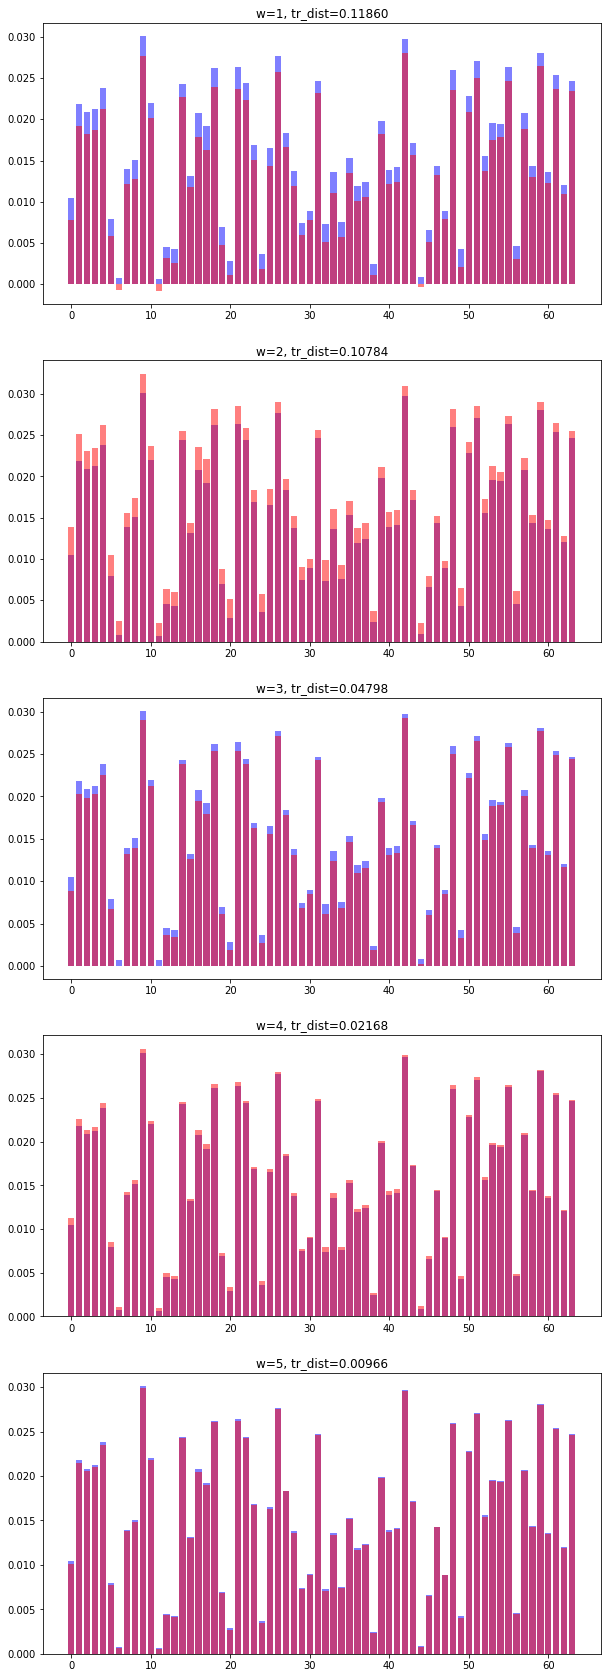

In [11]:
n_qubits = 6
q01_arr = [0.09, .07, 0.12, 0.08, 0.11, 0.06, 0.07, 0.11]
q10_arr = [0.04, .03, .05, 0.04, 0.03, .05, .04, 0.06]
R = response_matrix.Rmatrix(q01_arr[:n_qubits], q10_arr[:n_qubits])
Rinv = np.linalg.inv(R)
p_true = make_random(n_qubits)
p_prime = R @ p_true
x = np.arange(1 << n_qubits)

wvals = [1, 2, 3, 4, 5]

fig, axes = plt.subplots(len(wvals), 1, figsize=(10, 30))
kl_divs = []

for k, w in enumerate(wvals):
    # Empirically i observe that w1,w2 changing independently has little effect on performance
    p_fixed = response_matrix.invert_pfull_truncated(R, p_prime, w1=w, w2=w)
    axes[k].bar(x, p_true, alpha=0.5, label="true distr", color='b')
    axes[k].bar(x, p_fixed, alpha=0.5, label="fixed distr", color='r')
    
    kl_div = trace_dist(p_fixed, p_true)
    axes[k].set_title(f"w={w}, tr_dist={kl_div:3.5f}")
    kl_divs.append(kl_div)
    

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


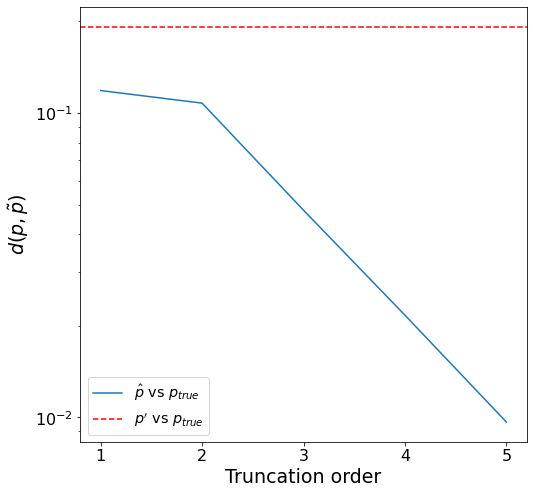

In [12]:
# Plot KL-div as a function of increasing cutoff
plt.style.use('./style.mplstyle')

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(wvals, kl_divs, label=r"$\hat{p}$ vs $p_{true}$")

# Compare to no error correction
initial_kl = trace_dist(p_prime, p_true)
ax.axhline(initial_kl, ls='--', c='r', label=r"$p'$ vs $p_{true}$")

# ax.set_title("KL_div vs. cutoff w")
ax.semilogy()
ax.set_xlabel(r"Truncation order")
ax.set_ylabel(r"$d(p, \tilde{p})$")
ax.set_xticks(wvals)
ax.legend(prop={'size': 'x-large'})

None

In [13]:
fig.savefig("figure1.pdf")